# ROC Curve
Vinicius Trevisan - 2021

This notebook is used to illustrate the medium article

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Create Synthetic Dataset

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
# Parameters for the synthetic data
scale = 5
size = 500

In [4]:
# Generate class 1 out of a normal distribution
class1_x = np.random.normal(loc = 10, scale = scale, size = size)
class1_y = np.random.normal(loc = 1, scale = scale, size = size)

In [5]:
# Generate class 2 out of a normal distribution
class2_x = np.random.normal(loc = 1, scale = scale, size = size)
class2_y = np.random.normal(loc = 5, scale = scale, size = size)

<AxesSubplot:>

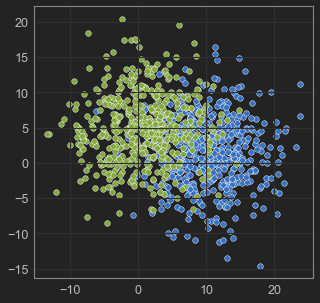

In [6]:
# Plot both to show how much they intersect
plt.figure(figsize=(5, 5))
sns.scatterplot(x = class1_x, y = class1_y)
sns.scatterplot(x = class2_x, y = class2_y)

Join both classes in a single dataframe and split the train and test sets

In [7]:
df_class1 = pd.DataFrame()
df_class1['x'] = class1_x
df_class1['y'] = class1_y
df_class1['class'] = 0

In [8]:
df_class2 = pd.DataFrame()
df_class2['x'] = class2_x
df_class2['y'] = class2_y
df_class2['class'] = 1

In [9]:
df = df_class1.append(df_class2, ignore_index = True)

In [10]:
# Get the dependent and independent variables
X = df.drop(columns = ['class'])
y = df['class']

In [11]:
# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

## Fit a simple classifier
In this case, the default instance of the Naïve Bayes classifier will be used, but really any other can also be used

In [12]:
from sklearn.naive_bayes import GaussianNB

In [13]:
# Create the model object
model = GaussianNB()

In [14]:
# Fit the model to the training data
model.fit(X_train, y_train)

GaussianNB()

In [15]:
# Predict the classes on the test data
y_pred = model.predict(X_test)

In [16]:
# Show the first 10 entries
y_pred[:10]

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int64)

In [17]:
# Predict the classes on the test data, and return the probabilities for each class
y_proba = model.predict_proba(X_test)

In [18]:
# Show the first 10 entries
y_proba[:10]

array([[0.01895875, 0.98104125],
       [0.99143427, 0.00856573],
       [0.68091846, 0.31908154],
       [0.09526609, 0.90473391],
       [0.06521634, 0.93478366],
       [0.2392251 , 0.7607749 ],
       [0.94746368, 0.05253632],
       [0.87285469, 0.12714531],
       [0.74431329, 0.25568671],
       [0.89157637, 0.10842363]])

<AxesSubplot:xlabel='x', ylabel='y'>

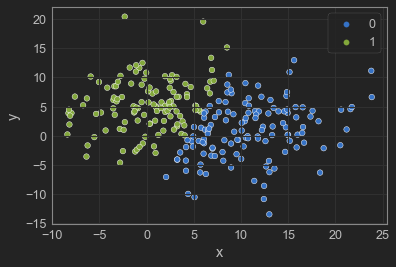

In [19]:
# Show the predictions
sns.scatterplot(x = X_test['x'], y = X_test['y'], hue = y_pred)

## Plot the ROC Curve
Manipulate the threshold to calculate some coordinates, and use them to plot the ROC Curve

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [22]:
def get_n_roc_coordinates(y_real, y_proba, resolution = 50):
    '''
    Calculates "n" ROC Curve coordinates (tpr and fpr) by manipulating the threshold used to predict the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        resolution: Defines how many divisions the threshold will have, and how many coordinates will be calculated (default = 50).
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(resolution):
        threshold = i/resolution
        y_pred = y_proba[:, 1] > threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [23]:
def plot_roc_curve(tpr, fpr, scatter = True):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    plt.figure(figsize = (5, 5))
    if scatter:
        sns.scatterplot(x = fpr, y = tpr)
    sns.lineplot(x = fpr, y = tpr)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [24]:
# Calculates 10 coordinates of the ROC Curve
tpr, fpr = get_n_roc_coordinates(y_test, y_proba, resolution = 10)

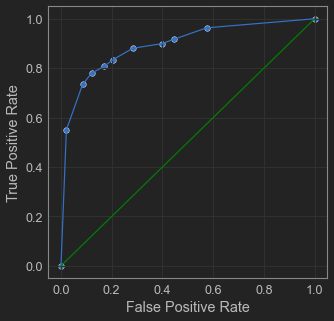

In [25]:
# Plots the ROC curve
plot_roc_curve(tpr, fpr)

## Better version
Use all data points to calculate the coordinates, and plots the ROC Curve

In [26]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i, 1]
        y_pred = y_proba[:, 1] >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [27]:
# Calculates ALL coordinates of the ROC Curve
tpr, fpr = get_all_roc_coordinates(y_test, y_proba)

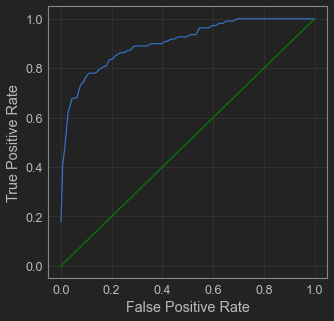

In [28]:
# Plots the ROC curve
plot_roc_curve(tpr, fpr, scatter = False)

## Compare with Sklearn

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

In [30]:
def plot_sklearn_roc_curve(y_real, y_pred):
    '''
    Plots the ROC Curve with the sklearn methods by using the real observations and their predictions.
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
    '''
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)

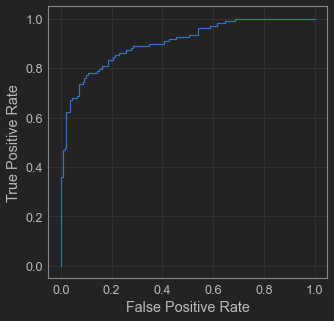

In [31]:
# Plots the ROC curve using the sklearn methods
plot_sklearn_roc_curve(y_test, y_proba[:, 1])

## Evaluate the classification using other metrics

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [33]:
def evaluate_classifier(y_real, y_pred):
    '''
    Prints the accuracy, precision, recall and roc auc scores for the classifier.
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
    '''
    print(f"Accuracy: {accuracy_score(y_real, y_pred):.4f}")
    print(f"Precision: {precision_score(y_real, y_pred):.4f}")
    print(f"Recall: {recall_score(y_real, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_real, y_pred):.4f}")

In [34]:
evaluate_classifier(y_test, y_pred)

Accuracy: 0.8120
Precision: 0.7583
Recall: 0.8349
ROC AUC: 0.8146
